## Loading and visualizig DICOM

This notebook demonstrates importing images in DICOM format to CERR's planC data structure and visualizing the imported objects. Phantom dataset made available by Lambin et al via CancerData and re-distributed along with the CERR package is used in this demonstration. Each patient daatset consists of CT scan for Lung and tumor segmentation.

#### Install pyCERR (development version)

In [ ]:
%%capture
pip install git+https://github.com/cerr/pyCERR/

#### Get a list of paths to patient datasets

In [1]:
from cerr import datasets
import os
phantom_dir = os.path.join(os.path.dirname(datasets.__file__),'radiomics_phantom_dicom')
pat_names = ['PAT1', 'PAT2', 'PAT3', 'PAT4']
all_pat_dirs = [os.path.join(phantom_dir, pat) for pat in pat_names]

#### Import contents of a patient directory to planC

In [2]:
# Import dicom to planC
from cerr import plan_container as pc
planC = pc.load_dcm_dir(all_pat_dirs[0])

('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.258301620411152643708006163321128526885', 'RTSTRUCT', '', '', '', '', '', '')
('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.296658988911737913102339329841519593982', 'CT', '', '', '', '', '', '')


#### Visualize scan and lung-tumor segmentation

Napari package is used for visualization. Napari requires a Display for rendering graphics and does not support visualization on a remote server (e.g. Google Colab)

In [3]:
from cerr import viewer as vwr
scanNum = [0]
doseNum = []
strNum = 0
displayMode = '2d' # '2d - path' or '3d - surface'
viewer, scan_layer, dose_layer, struct_layer = \
vwr.show_scan_struct_dose(scanNum, strNum, doseNum, planC, displayMode)

#### Adjust Visualization settings

Properties of Napari viewer and image "layers" can be readily accessed and updated. Below cell shows an example of changing opacity, contrast ranges and gamma scale.

In [4]:
scan_layer[0].opacity = 1
scan_layer[0].contrast_limits_range = [-1000, 300]
scan_layer[0].contrast_limits = [-900, 200]
scan_layer[0].gamma = 0.7

#### Programmatically capturing screenshots

Metadata can be accessed from planC to update the Viewer to programmatically capture image slices and objects of interest. The example below shows screenshot capture of tumor segmentation on central CT slice

In [5]:
from skimage.io import imsave, imshow
import os
import cerr.contour.rasterseg as rs
import numpy as np
save_dir = '/Users/aptea/Desktop/dcm_images'
# Get index of central axial slice
scanNum = 0 # index of scan in planC.scan
strNum = 0 # index of structure in planC.structure
mask3M = rs.getStrMask(strNum, planC)
rV, cV, sV = np.where(mask3M)
midSliceInd = int(np.round(sV.mean()))
# update viewer to display the central slice and capture screenshot
xV, yV, zV = planC.scan[scanNum].getScanXYZVals()
viewer.dims.set_point(2, zV[midSliceInd])
screenshot = viewer.screenshot()
capture_fname = os.path.join(save_dir,pat_names[0] + '.png')
imsave(capture_fname, screenshot)
print('saved to '+ capture_fname)

saved to /Users/aptea/Desktop/dcm_images/PAT1.png


#### Show the saved image

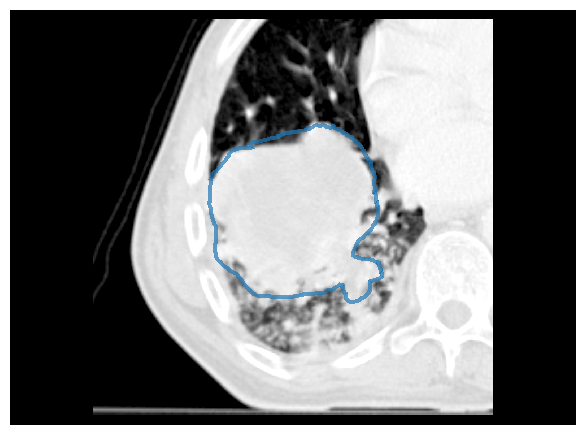

In [6]:
im = imshow(capture_fname)
im.axes.set_axis_off()